In [1]:
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import nmrglue as ng
import os
import os.path
import sys
import pandas as pd
%matplotlib inline

In [35]:
def _1Lorentzian(x, amp, cen, wid):
    return amp*wid**2/((x-cen)**2+wid**2)

def _2Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2))

def _3Lorentzian(x, amp1, cen1, wid1, amp2,cen2,wid2, amp3, cen3, wid3):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2)) +\
            (amp3*wid3**2/((x-cen3)**2+wid3**2))
             
            


def Lorentz_fit(ddir, max_ppm, min_ppm, inital_val, num_peak=1):
    # import data in nmrpipe format
    dic,data = ng.bruker.read_pdata(ddir)

    # generate the ppm/ Hz scale for the data
    udic=ng.bruker.guess_udic(dic,data)
    uc = ng.fileiobase.uc_from_udic(udic)
    
    #generate region for fitting
    ppm_a=uc.ppm_scale()
    data2=data[uc(max_ppm, 'ppm'): uc(min_ppm,'ppm')]
    ppm2=ppm_a[uc(max_ppm, 'ppm'): uc(min_ppm,'ppm')]
    
    #get the folder name; need be informative about the data
    dir_name=os.path.dirname(ddir)
    title=dir_name.split('/')[-2]
    
    # fitting with one Lorentz peak
    if num_peak ==1:
        amp1 = inital_val[0]
        wid1 = inital_val[1]
        cen1 = inital_val[2]
        popt_lorentz, pcov_lorentz = scipy.optimize.curve_fit(_1Lorentzian, ppm2, data2, p0=[amp1, cen1, wid1])
        perr_lorentz = np.sqrt(np.diag(pcov_lorentz))
        lorentz_peak = _1Lorentzian(ppm2, *popt_lorentz)
        # output fitting results
        print ('This is the fitting result for {}'.format(dir_name))
        print ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm))
        print ("-------------Peak-------------")
        print ('amplitude = {:0.2f} (+/-) {:0.2f}'.format(popt_lorentz[0], perr_lorentz[0]))
        print ("center = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[1], perr_lorentz[1]))
        print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[2], perr_lorentz[2]))
        print ("area = {:0.2f}".format( np.trapz(lorentz_peak)))
        print ("--------------------------------")
        
        
        with open("Lorentz_fit_{}.out".format(title), 'a') as f:
            f.write('This is the fitting result for {}'.format(dir_name)+'\n')
            f.write ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm)+'\n')
            f.write ("-------------Peak-------------")
            f.write ('amplitude = {:0.2f} (+/-) {:0.2f}'.format(popt_lorentz[0], perr_lorentz[0])+'\n')
            f.write("center = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[1], perr_lorentz[1])+'\n')
            f.write ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format(popt_lorentz[2], perr_lorentz[2])+'\n')
            f.write ("area = {:0.2f}".format( np.trapz(lorentz_peak))+'\n')
            f.write ("--------------------------------"+'\n')
            
     #make a figure for the fitting
        fig = plt.figure(figsize=(4,3))
        gs = gridspec.GridSpec(2,1,height_ratios=[1,0.25] )
        ax1 = fig.add_subplot(gs[0])
        ax2  =fig.add_subplot(gs[1])
        gs.update(hspace=0)

        ax1.plot(ppm2, data2, "r-")
        ax1.plot(ppm2, _1Lorentzian(ppm2, *popt_lorentz), 'k--')

        ax2.plot(ppm2,data2-_1Lorentzian(ppm2, *popt_lorentz), 'ro', markersize=3 )

        # # peak 1
        
        ax1.fill_between(ppm2, lorentz_peak.min(), lorentz_peak, facecolor="green", alpha=0.5)

        #ax1.xaxis.set_major_locator(ticker.AutoLocator())
        #ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.xaxis.set_major_locator(ticker.AutoLocator())
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax1.set_xlim(max_ppm, min_ppm)
        ax2.set_xlim(max_ppm, min_ppm)

        fig.tight_layout()
        fig.savefig("Lorentz_fit_{} {} to {}reduced.png".format(title,max_ppm, min_ppm), format="png",dpi=1000)
        
        #return popt_lorentz + perr_lorentz
        return np.concatenate((popt_lorentz,perr_lorentz),axis=0)
            
    elif num_peak ==2:
        amp1 = inital_val[0]
        wid1 = inital_val[1]
        cen1 = inital_val[2]
        amp2 = inital_val[3]
        wid2 = inital_val[4]
        cen2 = inital_val[5]
        popt_2lorentz, pcov_2lorentz = scipy.optimize.curve_fit(_2Lorentzian, ppm2, data2, p0=[amp1, cen1, wid1, \
                                                                                    amp2, cen2, wid2])

        perr_2lorentz = np.sqrt(np.diag(pcov_2lorentz))

        pars_1 = popt_2lorentz[0:3]
        pars_2 = popt_2lorentz[3:6]
        lorentz_peak_1 = _1Lorentzian(ppm2, *pars_1)
        lorentz_peak_2 = _1Lorentzian(ppm2, *pars_2)
        print ('This is the fitting result for {}'.format(dir_name))
        print ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm))
        print ("-------------Peak 1-------------")
        print ("amplitude = {:0.2f} (+/-) {:0.2f}" .format(pars_1[0], perr_2lorentz[0]))
        print ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_1[1], perr_2lorentz[1]))
        print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2], perr_2lorentz[2]))
        #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2]*2.35482, perr_2gauss[2]*2.35482))
        print ("area1 = {:0.2f}" .format( np.trapz(lorentz_peak_1)))
        print ("--------------------------------")
        print ("-------------Peak 2-------------")
        print ("amplitude = {:0.2f} (+/-) {:0.2f}".format(pars_2[0], perr_2lorentz[3]))
        print ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_2[1], perr_2lorentz[4]))
        print ("peakwidth = {:0.2f} (+/-) {:0.2f}".format (pars_2[2], perr_2lorentz[5]))
        #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_2[2]*2.35482, perr_2gauss[5]*2.35482))
        print ("area2 = {:0.2f}".format( np.trapz(lorentz_peak_2)))
        print ("--------------------------------")
        
        #write the output to a file
        with open("Lorentz_fit_{}.out".format(title), 'a') as f:
            f.write ('This is the fitting result for {}'.format(dir_name)+'\n')
            f.write ("---------fitting_region {} to {}------------".format(min_ppm, max_ppm)+'\n')
            f.write ("-------------Peak 1-------------"+'/n')
            f.write ("amplitude = {:0.2f} (+/-) {:0.2f}" .format(pars_1[0], perr_2lorentz[0])+'\n')
            f.write ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_1[1], perr_2lorentz[1])+'\n')
            f.write ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2], perr_2lorentz[2])+'\n')
            #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_1[2]*2.35482, perr_2gauss[2]*2.35482))
            f.write ("area1 = {:0.2f}" .format( np.trapz(lorentz_peak_1))+'\n')
            f.write ("--------------------------------"+'\n')
            f.write ("-------------Peak 2-------------"+'\n')
            f.write ("amplitude = {:0.2f} (+/-) {:0.2f}".format(pars_2[0], perr_2lorentz[3])+'\n')
            f.write ("center = {:0.2f} (+/-) {:0.2f}" .format(pars_2[1], perr_2lorentz[4])+'\n')
            f.write ("peakwidth = {:0.2f} (+/-) {:0.2f}".format (pars_2[2], perr_2lorentz[5])+'\n')
            #print ("peakwidth = {:0.2f} (+/-) {:0.2f}" .format (pars_2[2]*2.35482, perr_2gauss[5]*2.35482))
            f.write ("area2 = {:0.2f}".format( np.trapz(lorentz_peak_2))+'\n')
            f.write ("--------------------------------"+'\n')
        
        fig = plt.figure(figsize=(4,3))
        gs = gridspec.GridSpec(2,1,height_ratios=[1,0.25] )
        ax1 = fig.add_subplot(gs[0])
        ax2  =fig.add_subplot(gs[1])
        gs.update(hspace=0)

        ax1.plot(ppm2, data2, "r-")
        ax1.plot(ppm2, _2Lorentzian(ppm2, *popt_2lorentz), 'k--')

        ax2.plot(ppm2,data2-_2Lorentzian(ppm2, *popt_2lorentz), 'ro', markersize=3 )

        # peak 1
        ax1.plot(ppm2, lorentz_peak_1, "g")
        ax1.fill_between(ppm2, lorentz_peak_1.min(), lorentz_peak_1, facecolor="green", alpha=0.5)

        # peak 2
        ax1.plot(ppm2, lorentz_peak_2, "y")
        ax1.fill_between(ppm2, lorentz_peak_2.min(), lorentz_peak_2, facecolor="yellow", alpha=0.5) 

        #ax1.xaxis.set_major_locator(ticker.AutoLocator())
        #ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.xaxis.set_major_locator(ticker.AutoLocator())
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax1.set_xlim(max_ppm, min_ppm)
        ax2.set_xlim(max_ppm, min_ppm)

        fig.tight_layout()
        fig.savefig("Lorentz_fit_{} {} to {}reduced.png".format(title,max_ppm, min_ppm), format="png",dpi=1000)
        
        return  np.concatenate((popt_2lorentz,perr_2lorentz),axis=0)
    elif num_peak ==3:
        amp1 = inital_val[0]
        wid1 = inital_val[1]
        cen1 = inital_val[2]
        amp2 = inital_val[3]
        wid2 = inital_val[4]
        cen2 = inital_val[5]
        amp3 = inital_val[6]
        wid3 = inital_val[7]
        cen3 = inital_val[8]
        
        popt_3lorentz, pcov_3lorentz = scipy.optimize.curve_fit(_3Lorentzian, ppm2, data2, p0=[amp1, cen1, wid1, amp2, cen2, wid2,amp3, cen3, wid3])

        perr_3lorentz = np.sqrt(np.diag(pcov_3lorentz))

        pars_1 = popt_3lorentz[0:3]
        pars_2 = popt_3lorentz[3:6]
        pars_3 = popt_3lorentz[6:9]
        lorentz_peak_1 = _1Lorentzian(ppm2, *pars_1)
        lorentz_peak_2 = _1Lorentzian(ppm2, *pars_2)
        lorentz_peak_3 = _1Lorentzian(ppm2, *pars_3)
        
        #plotting the data
                
        fig = plt.figure(figsize=(4,3))
        gs = gridspec.GridSpec(2,1,height_ratios=[1,0.25] )
        ax1 = fig.add_subplot(gs[0])
        ax2  =fig.add_subplot(gs[1])
        gs.update(hspace=0)
        

        ax1.plot(ppm2, data2/max(data2), "r-")
        ax1.plot(ppm2, _3Lorentzian(ppm2, *popt_3lorentz)/max(data2), 'k--')

        ax2.plot(ppm2,(data2-_3Lorentzian(ppm2, *popt_3lorentz))/max(data2), 'ro', markersize=3 )

        # peak 1
        ax1.plot(ppm2, lorentz_peak_1/max(data2), "g")
        ax1.fill_between(ppm2, (lorentz_peak_1/max(data2)).min(), lorentz_peak_1/max(data2), facecolor="green", alpha=0.5)

        # peak 2
        ax1.plot(ppm2, lorentz_peak_2/max(data2), "y")
        ax1.fill_between(ppm2, (lorentz_peak_2/max(data2)).min(), lorentz_peak_2/max(data2), facecolor="yellow", alpha=0.5) 
        
        #peak 3
        ax1.plot(ppm2, lorentz_peak_3/max(data2), "b")
        ax1.fill_between(ppm2, (lorentz_peak_3/max(data2)).min(), lorentz_peak_3/max(data2), facecolor="blue", alpha=0.5)        

        #ax1.xaxis.set_major_locator(ticker.AutoLocator())
        #ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax2.xaxis.set_major_locator(ticker.AutoLocator())
        ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())

        ax1.set_xlim(max_ppm, min_ppm)
        ax2.set_xlim(max_ppm, min_ppm)
        ax1.axes.get_xaxis().set_visible(False)

        fig.tight_layout()
        fig.savefig("Lorentz_fit_{} {} to {}.png".format(title,max_ppm, min_ppm), format="png",dpi=1000)
        
        return  np.concatenate((popt_3lorentz,perr_3lorentz),axis=0)
        
    else:
        sys.exit('cannot fit, write your own program')

In [3]:
bas_ddir='/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60'
path_list = ['10','pdata','1']
data_path=os.path.join(bas_ddir, *path_list)
print(data_path)


/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/10/pdata/1


In [9]:
dir_name=os.path.dirname(data_path)
title=dir_name.split('/')[-2]
title

'10'

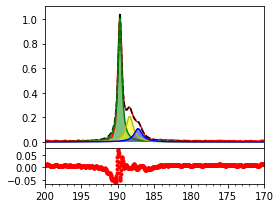

In [36]:
fit_re=Lorentz_fit(data_path, 200, 170, [1.2e10, 2, 190, 0.4e10, 5, 188, 0.4e10, 5, 187 ], 3)

In [181]:
df=pd.DataFrame(columns=['data', 'amp_1', 'amp_err_1','cen_1', 'cen_err_1', 'wid_1', 'wid_err_1','amp_2', 'amp_err_2','cen_2', 'cen_err_2', 'wid_2', 'wid_err_2','amp_3', 'amp_err_3','cen_3', 'cen_err_3', 'wid_3', 'wid_err_3'])


In [43]:

data_path_II=[]
for num in range(10, 33):
    path_list_II = [str(num),'pdata','1']
    data_path_II.append(os.path.join(bas_ddir, *path_list_II))
print(data_path_II)

['/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/10/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/11/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/12/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/13/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/14/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/15/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/16/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/17/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/18/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/19/pdata/1', '/Users/yunyao/Documents/Experiments_Data/data/Su

In [118]:
data_array=[]
ppm_array=[]
for item in data_path_II:
    dic, data=ng.bruker.read_pdata(item)
    data_array.append(data)
    udic=ng.bruker.guess_udic(dic,data)
    uc=ng.fileiobase.uc_from_udic(udic)
    ppm_scale=uc.ppm_scale()
    ppm_array.append(ppm_scale)
    

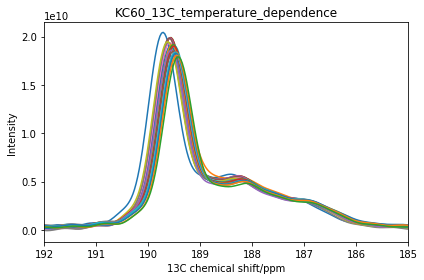

In [126]:
fig=plt.figure()
for sig, ppm in zip(data_array, ppm_array):
    plt.plot(ppm, sig)
plt.xlim(192, 185) 
plt.title('KC60_13C_temperature_dependence')
plt.xlabel('13C chemical shift/ppm')
plt.ylabel('Intensity')
#plt.xticks
plt.tight_layout()
fig.savefig("13C_NMR_KC60_Diff_temp.pdf",format='pdf', dpi=1000)



#plt.plot()

In [92]:
# enlarge area
#data_impurity=data
#ppm_scale_impurity=ppm_scale
data_signal=data[uc(195,'ppm'):uc(175,'ppm')]
data_inpurity=data[uc(140,'ppm'):uc(125,'ppm')]
ppm_scale_signal=ppm_scale[uc(195,'ppm'):uc(175,'ppm')]
ppm_scale_inpurity=ppm_scale[uc(140,'ppm'):uc(125,'ppm')]

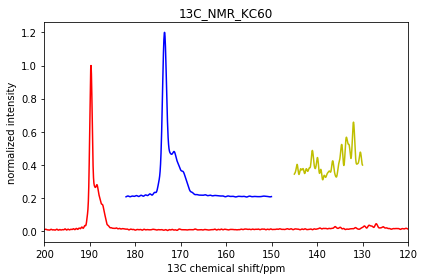

In [117]:
fig=plt.figure()
plt.plot(ppm_scale, data/max(data), 'r')
plt.plot((ppm_scale_signal)*1.6-130,data_signal/max(data)+0.2,'b')
plt.plot(ppm_scale_inpurity+5, data_inpurity/max(data)*10+0.2,'y')
plt.xlim(200, 120)
plt.xlabel('13C chemical shift/ppm')
plt.ylabel('normalized intensity')
plt.title("13C_NMR_KC60")
fig.tight_layout()
fig.savefig("13C_NMR_KC60_DP_292k.pdf",format='pdf', dpi=1000)


/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/26/pdata/1
/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/27/pdata/1
/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/28/pdata/1
/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/29/pdata/1
/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/30/pdata/1
/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/31/pdata/1
/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/32/pdata/1


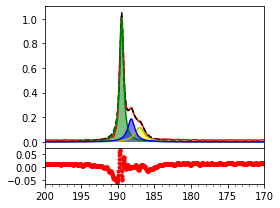

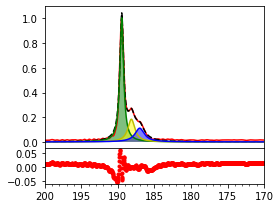

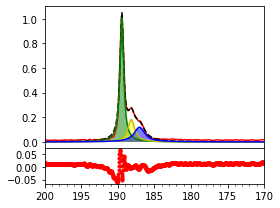

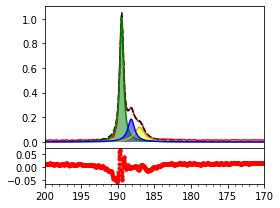

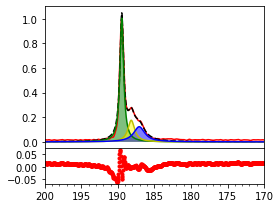

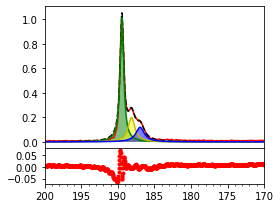

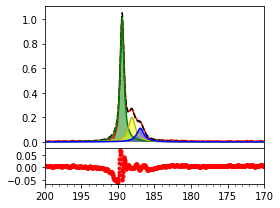

In [228]:
for item in data_path_II[16:33]:
    #print(item.split('/')[-3])
    print(item)
    fit_re=Lorentz_fit(item, 200, 170, [2e10, 0.3, 190, 0.4e10, 0.34, 188 ,1e9, 0.45, 186], 3)
    df=df.append({'data': item.split('/')[-3], 'amp_1': fit_re[0], 'amp_err_1': fit_re[9], \
                  'cen_1': fit_re[1], 'cen_err_1': fit_re[10], \
                  'wid_1': fit_re[2], 'wid_err_1': fit_re[11],  \
                  'amp_2': fit_re[3], 'amp_err_2': fit_re[12], \
                  'cen_2': fit_re[4], 'cen_err_2': fit_re[13], \
                  'wid_2': fit_re[5], 'wid_err_2': fit_re[14],  \
                  'amp_3': fit_re[6], 'amp_err_3': fit_re[15], \
                  'cen_3': fit_re[7], 'cen_err_3': fit_re[16], \
                  'wid_3': fit_re[8], 'wid_err_3': fit_re[17]  \
                 },ignore_index=True )

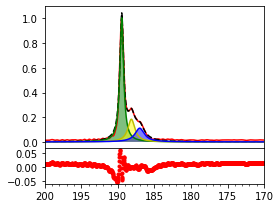

In [256]:
# test if the fitting is OK
ddir_tet="/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/27/pdata/1"
fit_re=Lorentz_fit(ddir_tet, 200, 170, [2e10, 0.3, 190, 0.4e10, 0.34, 188 ,1e9, 0.45, 186], 3)

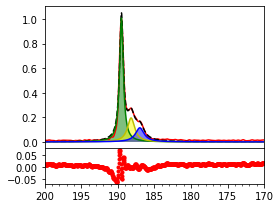

In [226]:
# after testing for particluar data set,which do not fit well with initial vaules
# new inital values are given
# if the results are good, write it to the dataframe
ddir_tet="/Users/yunyao/Documents/Experiments_Data/data/Superatom_2020/20200708_Yunyao_C60/25/pdata/1"
fit_re=Lorentz_fit(ddir_tet, 200, 170, [2e10, 0.3, 190, 0.4e10, 0.34, 188 ,1e9, 0.45, 186], 3)
df=df.append({'data': ddir_tet.split('/')[-3], 'amp_1': fit_re[0], 'amp_err_1': fit_re[9], \
                  'cen_1': fit_re[1], 'cen_err_1': fit_re[10], \
                  'wid_1': fit_re[2], 'wid_err_1': fit_re[11],  \
                  'amp_2': fit_re[3], 'amp_err_2': fit_re[12], \
                  'cen_2': fit_re[4], 'cen_err_2': fit_re[13], \
                  'wid_2': fit_re[5], 'wid_err_2': fit_re[14],  \
                  'amp_3': fit_re[6], 'amp_err_3': fit_re[15], \
                  'cen_3': fit_re[7], 'cen_err_3': fit_re[16], \
                  'wid_3': fit_re[8], 'wid_err_3': fit_re[17]  \
                 },ignore_index=True )
#ddir_tet.split('/')[-3]

In [205]:
df=df.drop([15], axis=0)

In [227]:
df

,data,amp_1,amp_err_1,cen_1,cen_err_1,wid_1,wid_err_1,amp_2,amp_err_2,cen_2,cen_err_2,wid_2,wid_err_2,amp_3,amp_err_3,cen_3,cen_err_3,wid_3,wid_err_3
0,10,2.058535e+10,1.008036e+08,189.709034,0.001530,0.304998,0.002760,4.227158e+09,1.096121e+08,188.388405,0.016417,0.600146,0.035559,2.198868e+09,1.208880e+08,187.229604,0.038102,0.664127,0.049027
1,11,1.758728e+10,8.601035e+07,189.479641,0.001670,0.334690,0.003062,4.034641e+09,8.917602e+07,188.196131,0.014707,0.603215,0.033636,2.116283e+09,1.060238e+08,187.060197,0.029862,-0.593791,0.041631
2,12,2.014241e+10,9.731489e+07,189.560143,0.001499,0.302165,0.002673,4.300186e+09,8.638845e+07,188.230547,0.013980,0.591244,0.030628,2.158949e+09,9.964094e+07,187.033044,0.029002,-0.579651,0.042573
3,13,2.016654e+10,9.872488e+07,189.562119,0.001534,0.304097,0.002712,4.276238e+09,8.918802e+07,188.234491,0.014078,0.577437,0.030677,2.236858e+09,1.008248e+08,187.048758,0.028761,-0.581440,0.041786
4,14,2.013306e+10,9.884542e+07,189.575846,0.001536,0.303810,0.002715,4.318414e+09,8.446786e+07,188.246915,0.013586,0.577740,0.029715,2.249693e+09,9.806099e+07,187.054031,0.026066,-0.546180,0.039575
5,15,2.012740e+10,1.031858e+08,189.585387,0.001587,0.301001,0.002806,4.315935e+09,8.527371e+07,188.247763,0.014054,0.584102,0.030713,2.177995e+09,1.005781e+08,187.041918,0.026826,-0.532441,0.041622
6,16,1.971211e+10,1.034592e+08,189.575106,0.001639,0.301793,0.002855,4.094337e+09,9.340256e+07,188.252071,0.014805,0.554118,0.031847,2.240258e+09,1.032865e+08,187.086884,0.029259,-0.567417,0.042644
7,17,1.978798e+10,1.096947e+08,189.605430,0.001727,0.301298,0.002990,4.163550e+09,9.086327e+07,188.270496,0.014603,0.550224,0.031361,2.172987e+09,1.043822e+08,187.091193,0.027045,-0.505682,0.042363
8,18,1.975202e+10,9.332081e+07,189.618419,0.001490,0.306129,0.002632,4.052464e+09,7.911813e+07,188.282337,0.013641,0.581271,0.029932,2.239798e+09,9.141183e+07,187.071865,0.024738,0.551199,0.037643
9,19,1.917422e+10,1.019710e+08,189.487582,0.001675,0.307690,0.003030,3.765379e+09,1.181118e+08,188.161864,0.019210,0.609207,0.041782,2.096531e+09,1.268814e+08,186.989518,0.044602,-0.710603,0.054483


In [225]:
df=df.drop([16],axis=0)

In [229]:
df

,data,amp_1,amp_err_1,cen_1,cen_err_1,wid_1,wid_err_1,amp_2,amp_err_2,cen_2,cen_err_2,wid_2,wid_err_2,amp_3,amp_err_3,cen_3,cen_err_3,wid_3,wid_err_3
0,10,2.058535e+10,1.008036e+08,189.709034,0.001530,0.304998,0.002760,4.227158e+09,1.096121e+08,188.388405,0.016417,0.600146,0.035559,2.198868e+09,1.208880e+08,187.229604,0.038102,0.664127,0.049027
1,11,1.758728e+10,8.601035e+07,189.479641,0.001670,0.334690,0.003062,4.034641e+09,8.917602e+07,188.196131,0.014707,0.603215,0.033636,2.116283e+09,1.060238e+08,187.060197,0.029862,-0.593791,0.041631
2,12,2.014241e+10,9.731489e+07,189.560143,0.001499,0.302165,0.002673,4.300186e+09,8.638845e+07,188.230547,0.013980,0.591244,0.030628,2.158949e+09,9.964094e+07,187.033044,0.029002,-0.579651,0.042573
3,13,2.016654e+10,9.872488e+07,189.562119,0.001534,0.304097,0.002712,4.276238e+09,8.918802e+07,188.234491,0.014078,0.577437,0.030677,2.236858e+09,1.008248e+08,187.048758,0.028761,-0.581440,0.041786
4,14,2.013306e+10,9.884542e+07,189.575846,0.001536,0.303810,0.002715,4.318414e+09,8.446786e+07,188.246915,0.013586,0.577740,0.029715,2.249693e+09,9.806099e+07,187.054031,0.026066,-0.546180,0.039575
5,15,2.012740e+10,1.031858e+08,189.585387,0.001587,0.301001,0.002806,4.315935e+09,8.527371e+07,188.247763,0.014054,0.584102,0.030713,2.177995e+09,1.005781e+08,187.041918,0.026826,-0.532441,0.041622
6,16,1.971211e+10,1.034592e+08,189.575106,0.001639,0.301793,0.002855,4.094337e+09,9.340256e+07,188.252071,0.014805,0.554118,0.031847,2.240258e+09,1.032865e+08,187.086884,0.029259,-0.567417,0.042644
7,17,1.978798e+10,1.096947e+08,189.605430,0.001727,0.301298,0.002990,4.163550e+09,9.086327e+07,188.270496,0.014603,0.550224,0.031361,2.172987e+09,1.043822e+08,187.091193,0.027045,-0.505682,0.042363
8,18,1.975202e+10,9.332081e+07,189.618419,0.001490,0.306129,0.002632,4.052464e+09,7.911813e+07,188.282337,0.013641,0.581271,0.029932,2.239798e+09,9.141183e+07,187.071865,0.024738,0.551199,0.037643
9,19,1.917422e+10,1.019710e+08,189.487582,0.001675,0.307690,0.003030,3.765379e+09,1.181118e+08,188.161864,0.019210,0.609207,0.041782,2.096531e+09,1.268814e+08,186.989518,0.044602,-0.710603,0.054483


In [230]:
new_df=df

In [234]:
temp=[291.7, 284.6, 280, 275,270, 265,260,255, 250, 295, 280, 285, 290, 300, 270, 305, 310, 315, 320, 325, 330, 335,340]

In [235]:
len(temp)

23

In [236]:
new_df['temp']=temp

In [237]:
new_df

,data,amp_1,amp_err_1,cen_1,cen_err_1,wid_1,wid_err_1,amp_2,amp_err_2,cen_2,cen_err_2,wid_2,wid_err_2,amp_3,amp_err_3,cen_3,cen_err_3,wid_3,wid_err_3,temp
0,10,2.058535e+10,1.008036e+08,189.709034,0.001530,0.304998,0.002760,4.227158e+09,1.096121e+08,188.388405,0.016417,0.600146,0.035559,2.198868e+09,1.208880e+08,187.229604,0.038102,0.664127,0.049027,291.7
1,11,1.758728e+10,8.601035e+07,189.479641,0.001670,0.334690,0.003062,4.034641e+09,8.917602e+07,188.196131,0.014707,0.603215,0.033636,2.116283e+09,1.060238e+08,187.060197,0.029862,-0.593791,0.041631,284.6
2,12,2.014241e+10,9.731489e+07,189.560143,0.001499,0.302165,0.002673,4.300186e+09,8.638845e+07,188.230547,0.013980,0.591244,0.030628,2.158949e+09,9.964094e+07,187.033044,0.029002,-0.579651,0.042573,280.0
3,13,2.016654e+10,9.872488e+07,189.562119,0.001534,0.304097,0.002712,4.276238e+09,8.918802e+07,188.234491,0.014078,0.577437,0.030677,2.236858e+09,1.008248e+08,187.048758,0.028761,-0.581440,0.041786,275.0
4,14,2.013306e+10,9.884542e+07,189.575846,0.001536,0.303810,0.002715,4.318414e+09,8.446786e+07,188.246915,0.013586,0.577740,0.029715,2.249693e+09,9.806099e+07,187.054031,0.026066,-0.546180,0.039575,270.0
5,15,2.012740e+10,1.031858e+08,189.585387,0.001587,0.301001,0.002806,4.315935e+09,8.527371e+07,188.247763,0.014054,0.584102,0.030713,2.177995e+09,1.005781e+08,187.041918,0.026826,-0.532441,0.041622,265.0
6,16,1.971211e+10,1.034592e+08,189.575106,0.001639,0.301793,0.002855,4.094337e+09,9.340256e+07,188.252071,0.014805,0.554118,0.031847,2.240258e+09,1.032865e+08,187.086884,0.029259,-0.567417,0.042644,260.0
7,17,1.978798e+10,1.096947e+08,189.605430,0.001727,0.301298,0.002990,4.163550e+09,9.086327e+07,188.270496,0.014603,0.550224,0.031361,2.172987e+09,1.043822e+08,187.091193,0.027045,-0.505682,0.042363,255.0
8,18,1.975202e+10,9.332081e+07,189.618419,0.001490,0.306129,0.002632,4.052464e+09,7.911813e+07,188.282337,0.013641,0.581271,0.029932,2.239798e+09,9.141183e+07,187.071865,0.024738,0.551199,0.037643,250.0
9,19,1.917422e+10,1.019710e+08,189.487582,0.001675,0.307690,0.003030,3.765379e+09,1.181118e+08,188.161864,0.019210,0.609207,0.041782,2.096531e+09,1.268814e+08,186.989518,0.044602,-0.710603,0.054483,295.0


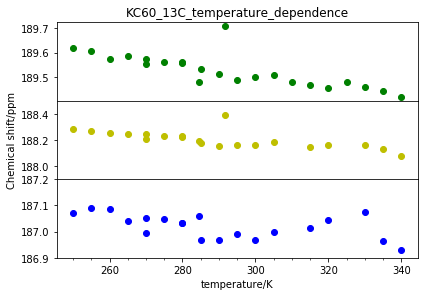

In [276]:
fig=plt.figure()
gs = gridspec.GridSpec(3,1 )
ax1=fig.add_subplot(gs[0])
ax2=fig.add_subplot(gs[1])
ax3=fig.add_subplot(gs[2])
gs.update(hspace=0)

ax1.plot(new_df['temp'], new_df['cen_1'], 'go')
ax2.plot(new_df['temp'], new_df['cen_2'], 'yo')
ax3.plot(new_df['temp'], new_df['cen_3'], 'bo')
ax2.set_ylim([187.9, 188.5 ])
ax3.set_ylim([186.9, 187.2 ])
ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.xlabel('temperature/K')
ax2.set_ylabel('Chemical shift/ppm')
plt.tight_layout()
ax1.set_title('KC60_13C_temperature_dependence')
plt.savefig('KC60_13C_temperature_dependence.pdf',format='pdf', dpi=1000,bbox_inches = "tight")

